## Import Dependencies and Data

In [1]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print("GPUs: ", gpus)

Num GPUs Available:  1
GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt


In [7]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  25%|██▌       | 1/4 [00:00<00:01,  2.03 url/s]

Dl Completed...:  50%|█████     | 2/4 [00:00<00:00,  2.93 url/s]

Dl Completed...:  75%|███████▌  | 3/4 [00:02<00:00,  1.06 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:06<00:00,  2.23s/ url]

Dl Completed...: 100%|██████████| 4/4 [00:06<00:00,  1.71s/ url]


Dataset fashion_mnist downloaded and prepared to C:\Users\bhavy\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds.as_numpy_iterator().next().keys() # shows the format of the data

dict_keys(['image', 'label'])

## Building the Data Pipeline and Visualizing the Data

In [10]:
import numpy as np

In [11]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator() # creates an iterator object , it will go through the dataset one by one

In [ ]:
dataiterator.next()['image'] 

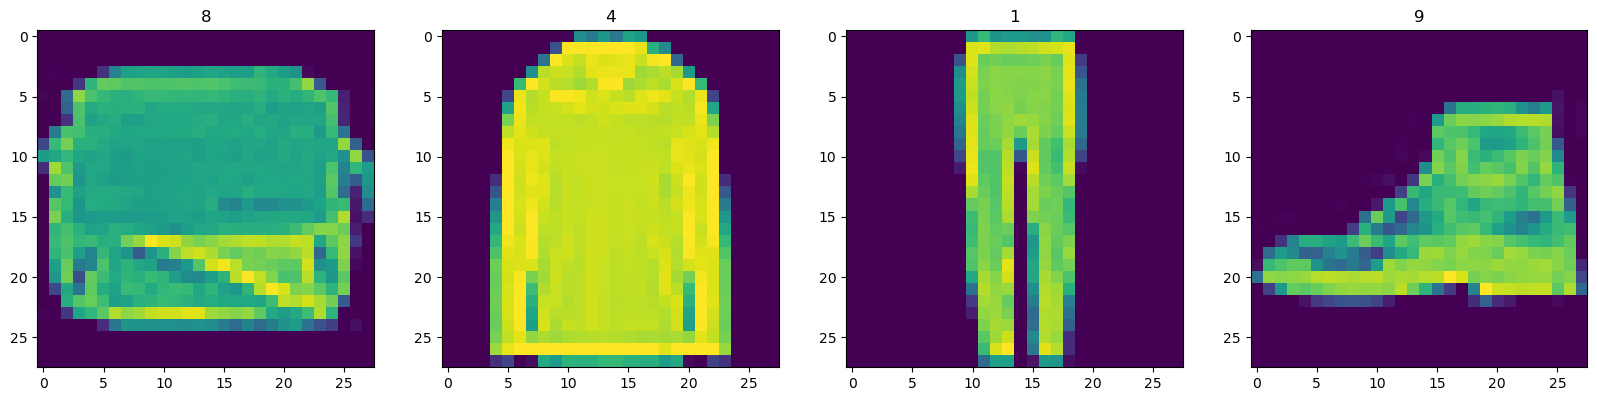

In [14]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get four images
for idx in range(4):  
    # Grab an image and label
    sample = dataiterator.next() # gets the next image in the dataset
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image'])) # it removes single-dimensional entries from the shape of an array i.e it converts (28,28,1) to (28,28)
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label']) # the label is a number from 0-9 representing the type of clothing

In [15]:
# Scale and return images only 
def scale_images(data): 
    image = data['image'] # grabs the image only
    return image / 255 # scales the image to be between 0 and 1 as oposed to 0-255